# ДЗ №3 
## Обучение моделей глубокого обучения на PyTorch

In [1]:
!pip3 install torch torchvision numpy matplotlib

Ваша задача на этой неделе - повторить модель трёхслойного перцептрона из прошолго задания на **PyTorch**, разобрать лучшие практики обучения моделей глубокого обучения и провести серию экспериментов

In [2]:
import torch
import torchvision
import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from typing import Tuple, List, Type, Dict, Any

Для того, чтобы эксперимент можно было повторить, хорошей практикой будет зафиксировать генератор случайных чисел. Также, рекоммендуется зафиксировать RNG в numpy и, если в качестве бэкенда используется cudnn - включить детерминированный режим.

Подробнее: https://pytorch.org/docs/stable/notes/randomness.html

In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### Модель

Основным способом организации кода на **Pytorch** является модуль. Простые модели могут быть реализованны из готовых модулей ( к примеру, `torch.nn.Sequential`, `torch.nn.Linear` и т.д. ), для более сложных архитектур часто приходтся реализовывать собственные блоки. Это достаточно легко сделать - достаточно написать класс, наследуемый от `torch.nn.Module` и реализующий метод `.forward`, который принимает и возвращает тензоры ( `torch.Tensor` ). Чаще всего этого достаточно и писать реализацию метода `backward` не нужно: за вас это сделает библиотека автоматического вычисления градиентов, реализованная в **Pytorch**.

Пример реализации кастомного модуля из официальной документации: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Здесь нелишним будет напомнить, что в подходе, используемом в Pytorch, все обучаемые параметры модуля должны существовать как атрибуты экземпляра этого модуля. То есть, объекты, соответствующие исполняемым объектам (`callable`), содержащим обучаемые параметры модуля, должны быть атрибутами этого модуля (`self.xxx`) и должны быть созданы в методе `__init__()`. При этом применяться к данным они должны в методе `forward()` этого модуля.

#### Задание 1

Повторите реализацию трёхслойного перцептрона из предыдущего задания на **Pytorch**. Желательно также, чтобы реализация модели имела параметризуемую глубину ( количество слоёв ), количество параметров на каждом слое и функцию активации. Отсутствие такой возможности не снижает балл, но сильно поможет в освоении принципов построения нейросетей с применением библиотеки pytorch.

In [5]:
class MultiLayerPerceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1,
                 hidden_layer_features: int = 128,
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super(MultiLayerPerceptron, self).__init__()
        
        self.input_features = input_resolution[0] * input_resolution[1] * input_channels
        self.hidden_features = hidden_layer_features
        self.output_features = num_classes
        
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=self.input_features, out_features=self.hidden_features)
        self.activation = activation()
        self.linear2 = torch.nn.Linear(in_features=self.hidden_features, out_features=self.output_features)
    
    def forward(self, x):
        y = self.flatten(x)  # преобразуем в одномерный вектор
        y = self.linear1(y)  # первый линейный слой
        y = self.activation(y)  # прогоняем через функцию актиывации после первого линейного слоя
        y = self.linear2(y)  # второй линейный слой
        
        return y # возвращаем по сути логиты, так как потом будем использовать torch.nn.CrossEntropyLoss

Следующий код позволяет посмотреть архитектуру получившейся модели и общее количество обучаемых параметров. Мы хотим, чтобы количество параметров в модели было порядка сотен тысяч. Если у вас получается больше или меньше, попробуйте изменить архитектуру модели.

In [7]:
model = MultiLayerPerceptron()
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

MultiLayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)
Total number of trainable parameters 101770


### Обучающая выборка

На практике, наиболее важным для успеха обучения любой модели машинного обучения является этап подготовки данных. Модели глубокого обучения не являются исключением. Большая, чистая, репрезентативная и релевантная поставленной задаче обучающая выборка часто важнее, чем архитектура самой модели. В предлагаемой задаче используется качественный и проверенный временем MNIST. Однако в практических задачах часто будет получаться так, что лучшим способом добиться улучшения качества модели будет сбор дополнительных данных и очистка исходных данных.

### Предобработка данных

Для улучшения сходимости алгоритма обучения и качества полученной модели данные могут быть предварительно обработаны:

1. Среднее каждой входной переменной близко к нулю
2. Переменные отмасштабированы таким образом, что их дисперсии примерно одинаковы ( из соображений вычислительной устойчивости, мы хотим, чтобы все величины по порядку величины были близки к единице )
3. По возможности, входные переменные не должны быть скоррелированны. Важнось этого пункта в последние годы ставится под сомнение, но всё-же в некоторых случаях это может влиять на результат

Подробнее можно почитать здесь: http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf

### Аугментация (искусственное дополнение) обучающей выборки

В зависимости от задачи можно применять к признаковому описанию объектов обучающей выборки различные преобразования, которые позволят увеличить эффективный размер выборки без дополнительной разметки. К примеру, для задачи классификации кошек и собак можно зеркально отразить изображение вокруг вертикальной оси - при этом класс изображения не изменится, а само изображение останется по прежнему будет принадлежать исходному распределению. Есть много разных техник аугментации, и их применимость и эффективность сильно зависит от данных и задачи.

Подробнее можно почитать здесь: https://link.springer.com/content/pdf/10.1186/s40537-019-0197-0.pdf

### Задание 2

Обоснуйте, почему аугментация обучающей выборки позволяет добиться прироста качества модели, несмотря на то, что она не добавляет в неё дополнительную информацию.

**Ответ:** По одному из определений, аугментация - процесс порождения новых данных на основе уже имеющихся. Данная техника часто используется в прикладных целях машинного обучения, так как почти всегда данных мало, а их хочется больше, чтобы устойчиво обучить модель.

Тогда, было предложено применять к данным некоторые преобразования, которые при этом имеют и логические обоснования. По сути аугментирировать пытаются данные так, чтобы на выходе получались потенциально возможные данные в реальном мире, но с некоторыми дефектами, вызванными некачественной камерой, снимающей объект, другим ракурсом съемки, другой освященностью, бликами, шумами и так далее. То есть на выходе получается, что модель при обучении успела увидеть и оригинальные данные, и "испорченные" экзогенно, что ведет к большей стабильности модели в реальных боевых условиях.

### Задание 3

Какие осмысленные аугментации вы можете придумать для следующих наборов данных:

1. Набор изображений животных, размеченый на виды животных
2. Набор аудиозаписей голоса, размечеными на языки говорящего
3. Набор cо показаниями датчиков температуры, влажности и давления с одной из метеостанций, размеченый на признак наличия осадков

**Ответ:**

1) Аффинные преобразования (сжатие, поворот, сдвиг), добавление бликов, шума

2) Добавление шума, изменение скорости, сдвиг аудиосигнала

3) Добавление шума к признакам, добавление данных с других станций

### Задание 4

Напишите пайплайн для предобработки и аугументации данных. В `torchvision.transforms` есть готовые реализации большинства распространённых техник. Если вы хотите добавить что-то своё, вы можете воспользоваться `torchvision.transforms.Lambda`. При этом следует понимать, что если нужно оценить качество модели на оригинальных данных, пайплайн предварительной обработки данных валидационной выборки не должен включать аугментаций. Следует помнить, однако, что существует подход аугментации данных в момент применения модели (test-time augmentation), который позволяет повысить качество модели в режиме исполнения.

Одним из обязательных шагов в вашем пайплайне должна быть конвертация данных в тензоры Pytorch (`torch.Tensor`): `torchvision.transforms.ToTensor()`.

In [8]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
    torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    torchvision.transforms.RandomAffine(degrees=40),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])

In [9]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

Перед тем как запускать обучение всегда стоит посмотреть на данные после предобработки, и удостовериться, что они соответствуют ожидаемым

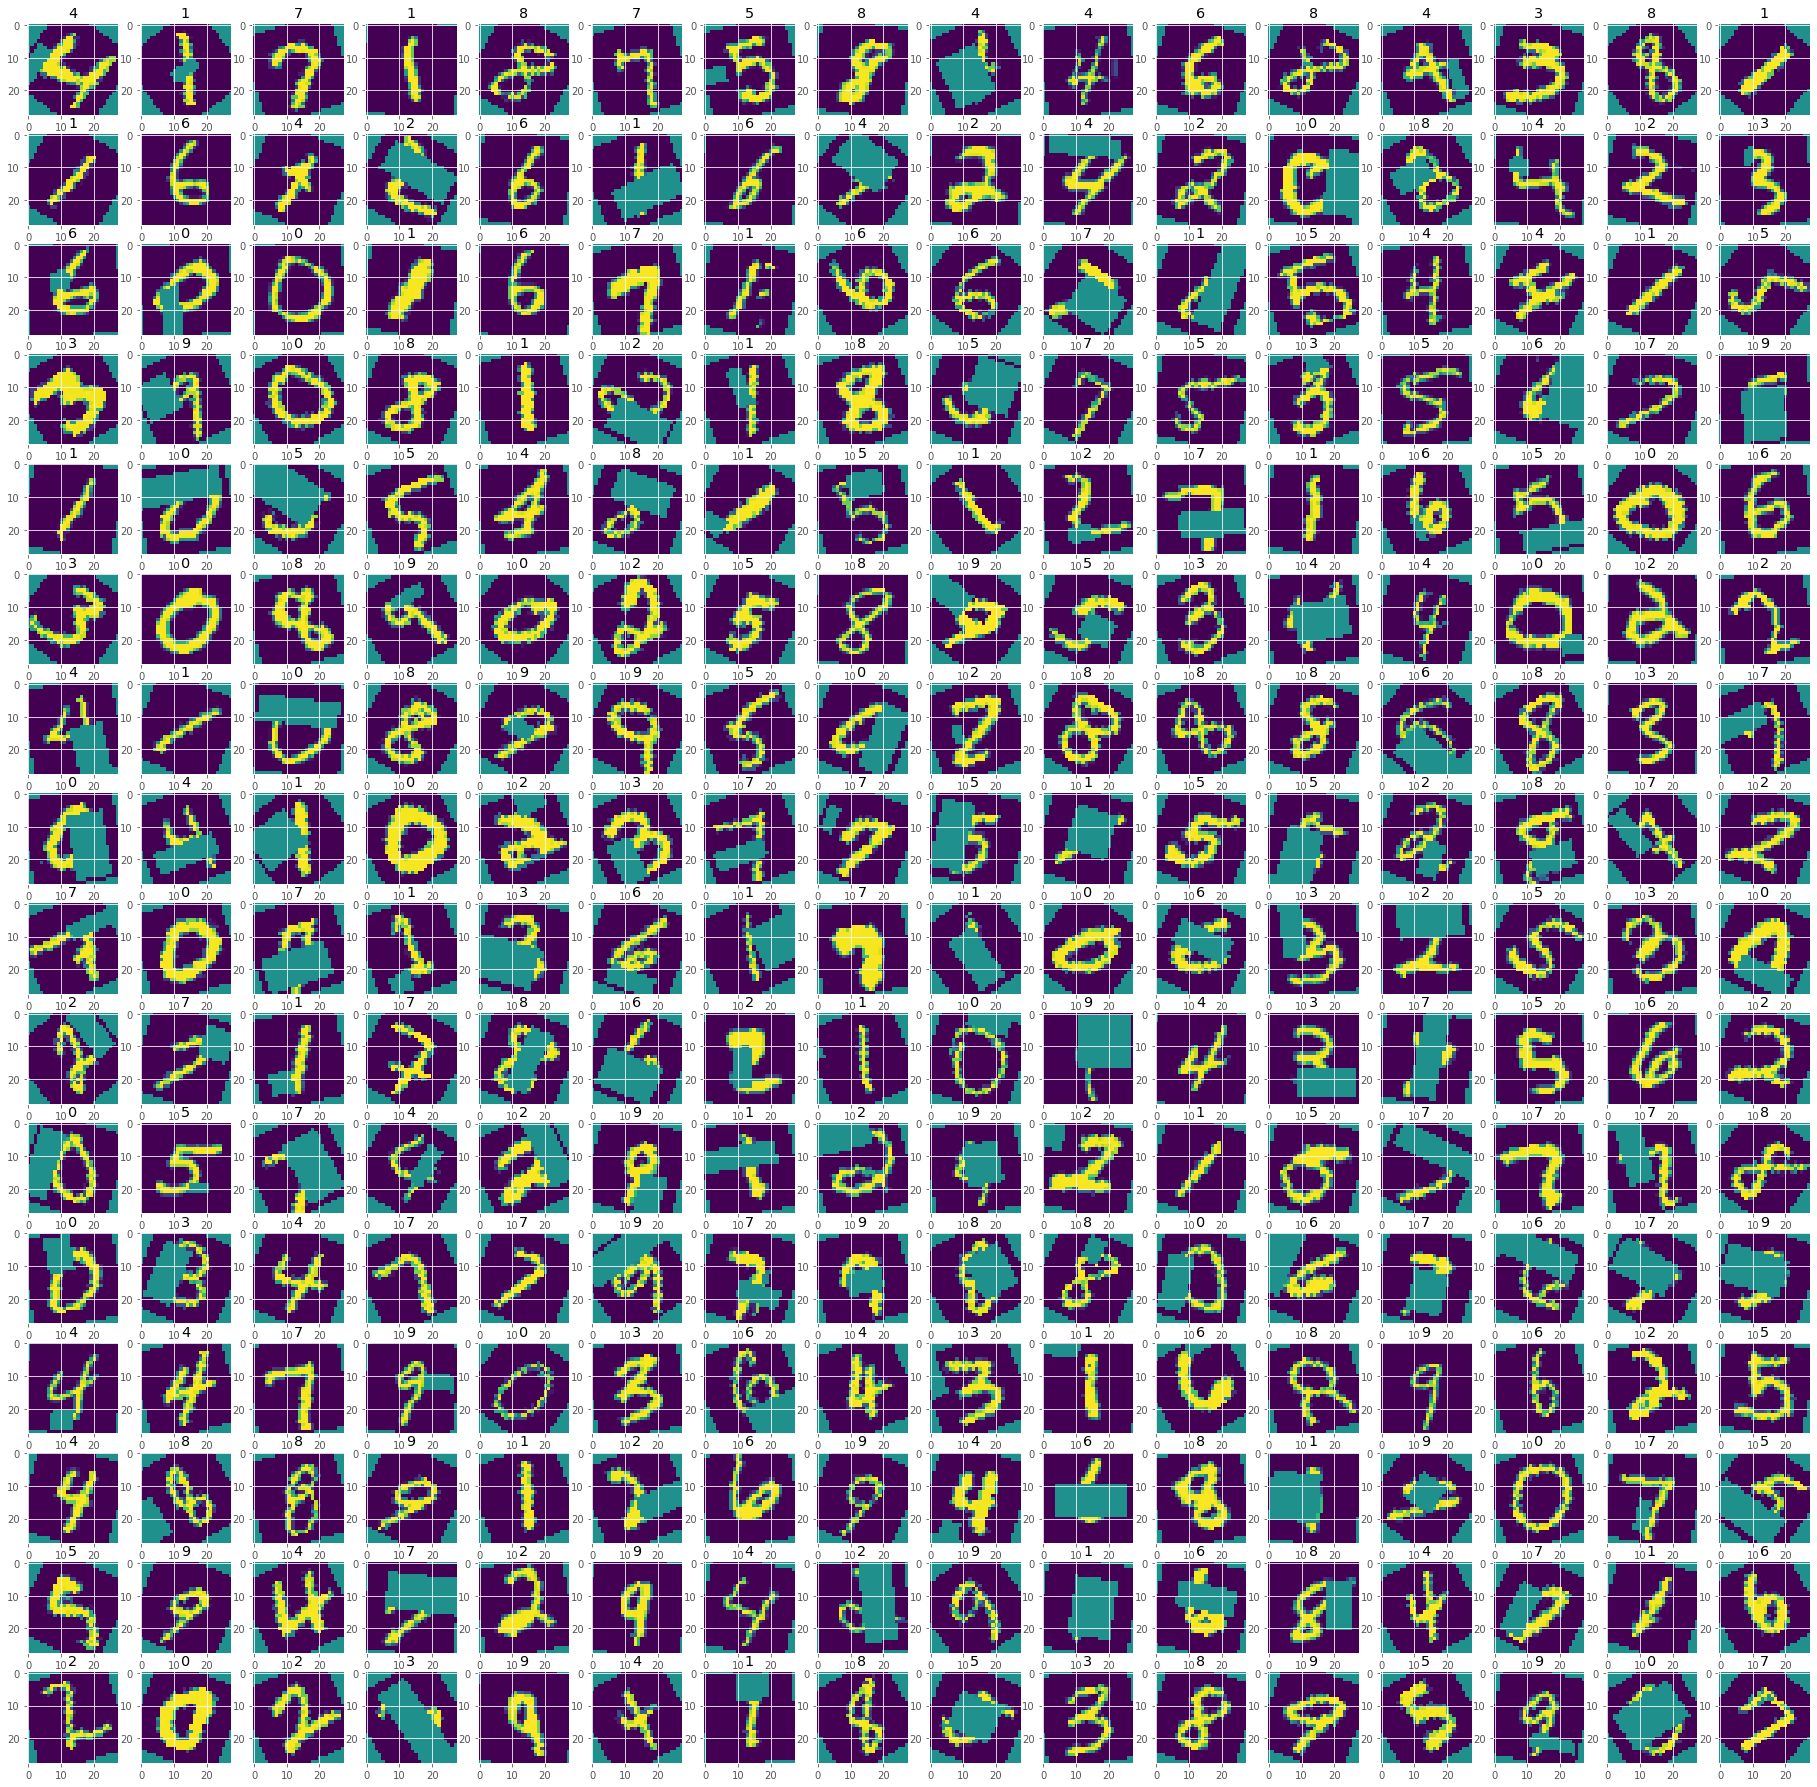

In [10]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=16, ncols=16, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*16+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0).squeeze())
        ax.set_title(label)

### Обучение модели

Теперь, когда мы реализовали модель и подготовили данные мы можем приступить к непосредственному обучению модели. Костяк функции обучения написан ниже, далее вы должны будете реализовать ключевые части этого алгоритма

In [11]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 128,
                max_epochs = 100,
                early_stopping_patience = 20):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)  # инициализация метода оптимизации Adam
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)  # инициализация sheduler'a для learning rate 
    
    # объекты-генераторы для итерации батчами
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None

    train_loss_history = []
    val_loss_history = []
    
    for epoch in tqdm(range(max_epochs)):
        
        print(f'Epoch {epoch}')
        
        train_avg_loss = train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            break
        
        train_loss_history.append(train_avg_loss)
        val_loss_history.append(val_metrics['loss'])


    return {'train': train_loss_history, 'val': val_loss_history}

### Задание 5

Реализуйте функцию, производящую обучение сети на протяжении одной эпохи ( полного прохода по всей обучающей выборке ). На вход будет приходить модель, оптимизатор, функция потерь и объект типа `DataLoader`. При итерировании по `data_loader` вы будете получать пары вида ( данные, целевая_переменная )

In [14]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    # переключаем в режим обучения
    model.train()

    size = len(data_loader.dataset)
    aggr_loss = 0
    for batch_number, (X_batch, y_batch) in enumerate(data_loader):
        # переключаем по возможности на GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # зануляем градинеты, так как torch их аккумулирует
        optimizer.zero_grad()

        # forward + loss + backward
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        aggr_loss += loss.item()
        loss.backward()

        # шаг оптимизиации
        optimizer.step()


    return aggr_loss / size

### Задание 6

Реализуйте функцию производящую вычисление функции потерь на валидационной выборке.  На вход будет приходить модель, функция потерь и `DataLoader`. На выходе ожидается словарь с вида:
```
{
    'loss': <среднее значение функции потерь>,
    'accuracy': <среднее значение точности модели>
}
```

In [15]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    size = len(data_loader.dataset)

    # переключаем модель в inference режим
    model.eval()

    aggr_epoch_loss = 0
    aggr_epoch_accuracy = 0
    with torch.no_grad():  # менеджер контекста для отключения вычисления градиента
        for current_batch, (X_batch, y_batch) in enumerate(data_loader):
            # переключаем по возможности на GPU
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # forward + loss
            y_pred = model(X_batch)
            aggr_epoch_loss += loss_function(y_pred, y_batch).item()
            aggr_epoch_accuracy += (y_pred.argmax(1) == y_batch).type(torch.float).sum().item()

    avg_epoch_loss = aggr_epoch_loss / size
    avg_epoch_accuracy = aggr_epoch_accuracy / size

    return {'loss': avg_epoch_loss, 'accuracy': avg_epoch_accuracy}

Если вы корректно реализовали все предыдущие шаги и ваша модель имеет достаточное количество обучаемых параметров, то в следующей ячейке должен пойти процесс обучения, и мы должны достичь итоговой точности (в смысле меры accuracy, доли верных ответов) выше 90%

In [17]:
model.to(device)

loss_history_1 = train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01,
            max_epochs=50)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0



  2%|▏         | 1/50 [00:45<37:31, 45.95s/it]

Validation metrics: 
{'loss': 0.0023847870342433453, 'accuracy': 0.9084}
Best model yet, saving
Epoch 1



  4%|▍         | 2/50 [01:31<36:45, 45.96s/it]

Validation metrics: 
{'loss': 0.00237803056826815, 'accuracy': 0.9008}
Best model yet, saving
Epoch 2



  6%|▌         | 3/50 [02:17<35:57, 45.91s/it]

Validation metrics: 
{'loss': 0.0024647783166728914, 'accuracy': 0.9022}
Epoch 3



  8%|▊         | 4/50 [03:03<35:11, 45.91s/it]

Validation metrics: 
{'loss': 0.002212045476259664, 'accuracy': 0.9153}
Best model yet, saving
Epoch 4



 10%|█         | 5/50 [03:49<34:20, 45.80s/it]

Validation metrics: 
{'loss': 0.0021853329379577188, 'accuracy': 0.916}
Best model yet, saving
Epoch 5



 12%|█▏        | 6/50 [04:34<33:35, 45.80s/it]

Validation metrics: 
{'loss': 0.0023425105415284635, 'accuracy': 0.9089}
Epoch 6



 14%|█▍        | 7/50 [05:20<32:46, 45.73s/it]

Validation metrics: 
{'loss': 0.002215468130726367, 'accuracy': 0.9192}
Epoch 7



 16%|█▌        | 8/50 [06:06<31:57, 45.66s/it]

Validation metrics: 
{'loss': 0.002198145944904536, 'accuracy': 0.9164}
Epoch 8



 18%|█▊        | 9/50 [06:52<31:20, 45.85s/it]

Validation metrics: 
{'loss': 0.0025839674273505807, 'accuracy': 0.9029}
Epoch 9



 20%|██        | 10/50 [07:37<30:27, 45.69s/it]

Validation metrics: 
{'loss': 0.002383329226821661, 'accuracy': 0.9081}
Epoch 10



 22%|██▏       | 11/50 [08:22<29:37, 45.57s/it]

Validation metrics: 
{'loss': 0.0024549951871857046, 'accuracy': 0.9087}
Epoch 11



 24%|██▍       | 12/50 [09:08<28:52, 45.58s/it]

Validation metrics: 
{'loss': 0.002242503855470568, 'accuracy': 0.9184}
Epoch 12



 26%|██▌       | 13/50 [09:53<28:01, 45.46s/it]

Validation metrics: 
{'loss': 0.002079832243081182, 'accuracy': 0.9204}
Best model yet, saving
Epoch 13



 28%|██▊       | 14/50 [10:39<27:17, 45.49s/it]

Validation metrics: 
{'loss': 0.0021269290547817946, 'accuracy': 0.9189}
Epoch 14



 30%|███       | 15/50 [11:24<26:29, 45.40s/it]

Validation metrics: 
{'loss': 0.002173638569097966, 'accuracy': 0.9132}
Epoch 15



 32%|███▏      | 16/50 [12:09<25:43, 45.40s/it]

Validation metrics: 
{'loss': 0.0023130296921357514, 'accuracy': 0.9116}
Epoch 16



 34%|███▍      | 17/50 [12:55<24:57, 45.39s/it]

Validation metrics: 
{'loss': 0.0020452045768499373, 'accuracy': 0.9215}
Best model yet, saving
Epoch 17



 36%|███▌      | 18/50 [13:40<24:14, 45.44s/it]

Validation metrics: 
{'loss': 0.0025055479157716034, 'accuracy': 0.9071}
Epoch 18



 38%|███▊      | 19/50 [14:26<23:27, 45.39s/it]

Validation metrics: 
{'loss': 0.0020660054029896856, 'accuracy': 0.9185}
Epoch 19



 40%|████      | 20/50 [15:11<22:41, 45.39s/it]

Validation metrics: 
{'loss': 0.0025848252268508075, 'accuracy': 0.9002}
Epoch 20



 42%|████▏     | 21/50 [15:56<21:56, 45.40s/it]

Validation metrics: 
{'loss': 0.0023646452374756336, 'accuracy': 0.9086}
Epoch 21



 44%|████▍     | 22/50 [16:42<21:11, 45.40s/it]

Validation metrics: 
{'loss': 0.0019133183698169887, 'accuracy': 0.9236}
Best model yet, saving
Epoch 22



 46%|████▌     | 23/50 [17:27<20:27, 45.48s/it]

Validation metrics: 
{'loss': 0.0023060562637634576, 'accuracy': 0.9103}
Epoch 23



 48%|████▊     | 24/50 [18:13<19:44, 45.56s/it]

Validation metrics: 
{'loss': 0.002020496389036998, 'accuracy': 0.9227}
Epoch 24



 50%|█████     | 25/50 [18:59<18:57, 45.52s/it]

Validation metrics: 
{'loss': 0.0022427946167066694, 'accuracy': 0.9149}
Epoch 25



 52%|█████▏    | 26/50 [19:44<18:10, 45.44s/it]

Validation metrics: 
{'loss': 0.0017434059930965305, 'accuracy': 0.9338}
Best model yet, saving
Epoch 26



 54%|█████▍    | 27/50 [20:29<17:24, 45.41s/it]

Validation metrics: 
{'loss': 0.0023869041427969934, 'accuracy': 0.908}
Epoch 27



 56%|█████▌    | 28/50 [21:14<16:37, 45.33s/it]

Validation metrics: 
{'loss': 0.0021119001628831027, 'accuracy': 0.923}
Epoch 28



 58%|█████▊    | 29/50 [22:00<15:52, 45.35s/it]

Validation metrics: 
{'loss': 0.0018819791700225323, 'accuracy': 0.9281}
Epoch 29



 60%|██████    | 30/50 [22:45<15:04, 45.22s/it]

Validation metrics: 
{'loss': 0.002338543845433742, 'accuracy': 0.9045}
Epoch 30



 62%|██████▏   | 31/50 [23:30<14:17, 45.12s/it]

Validation metrics: 
{'loss': 0.0022136947005987166, 'accuracy': 0.9139}
Epoch 31



 64%|██████▍   | 32/50 [24:15<13:31, 45.07s/it]

Validation metrics: 
{'loss': 0.0023041523437947035, 'accuracy': 0.9129}
Epoch 32



 66%|██████▌   | 33/50 [25:00<12:47, 45.12s/it]

Validation metrics: 
{'loss': 0.0023213841849938034, 'accuracy': 0.9149}
Epoch 33



 68%|██████▊   | 34/50 [25:45<12:04, 45.26s/it]

Validation metrics: 
{'loss': 0.001980213719047606, 'accuracy': 0.9221}
Epoch 34



 70%|███████   | 35/50 [26:31<11:20, 45.35s/it]

Validation metrics: 
{'loss': 0.00199880722775124, 'accuracy': 0.9239}
Epoch 35



 72%|███████▏  | 36/50 [27:16<10:33, 45.26s/it]

Validation metrics: 
{'loss': 0.002393413205072284, 'accuracy': 0.9063}
Epoch 36



 74%|███████▍  | 37/50 [28:01<09:47, 45.22s/it]

Validation metrics: 
{'loss': 0.002072648633737117, 'accuracy': 0.9237}
Epoch 37



 76%|███████▌  | 38/50 [28:48<09:07, 45.65s/it]

Validation metrics: 
{'loss': 0.001453554434981197, 'accuracy': 0.9425}
Best model yet, saving
Epoch 38



 78%|███████▊  | 39/50 [29:36<08:30, 46.43s/it]

Validation metrics: 
{'loss': 0.0014271697441581637, 'accuracy': 0.944}
Best model yet, saving
Epoch 39



 80%|████████  | 40/50 [30:25<07:51, 47.11s/it]

Validation metrics: 
{'loss': 0.0014118635054677724, 'accuracy': 0.9437}
Best model yet, saving
Epoch 40



 82%|████████▏ | 41/50 [31:12<07:04, 47.19s/it]

Validation metrics: 
{'loss': 0.00137416852558963, 'accuracy': 0.9448}
Best model yet, saving
Epoch 41



 84%|████████▍ | 42/50 [31:59<06:17, 47.19s/it]

Validation metrics: 
{'loss': 0.0013397977354936302, 'accuracy': 0.9484}
Best model yet, saving
Epoch 42



 86%|████████▌ | 43/50 [32:47<05:30, 47.27s/it]

Validation metrics: 
{'loss': 0.0013942883637268096, 'accuracy': 0.9436}
Epoch 43



 88%|████████▊ | 44/50 [33:34<04:43, 47.29s/it]

Validation metrics: 
{'loss': 0.00132802822208032, 'accuracy': 0.9465}
Best model yet, saving
Epoch 44



 90%|█████████ | 45/50 [34:23<03:58, 47.68s/it]

Validation metrics: 
{'loss': 0.001349789168825373, 'accuracy': 0.9465}
Epoch 45



 92%|█████████▏| 46/50 [35:12<03:12, 48.08s/it]

Validation metrics: 
{'loss': 0.0013493899137247353, 'accuracy': 0.9447}
Epoch 46



 94%|█████████▍| 47/50 [36:01<02:25, 48.40s/it]

Validation metrics: 
{'loss': 0.0014027298278175295, 'accuracy': 0.9448}
Epoch 47



 96%|█████████▌| 48/50 [36:49<01:36, 48.44s/it]

Validation metrics: 
{'loss': 0.001367512866621837, 'accuracy': 0.9452}
Epoch 48



 98%|█████████▊| 49/50 [37:37<00:48, 48.36s/it]

Validation metrics: 
{'loss': 0.0013737330314237625, 'accuracy': 0.9454}
Epoch 49



100%|██████████| 50/50 [38:25<00:00, 46.11s/it]

Validation metrics: 
{'loss': 0.001369120749924332, 'accuracy': 0.9452}


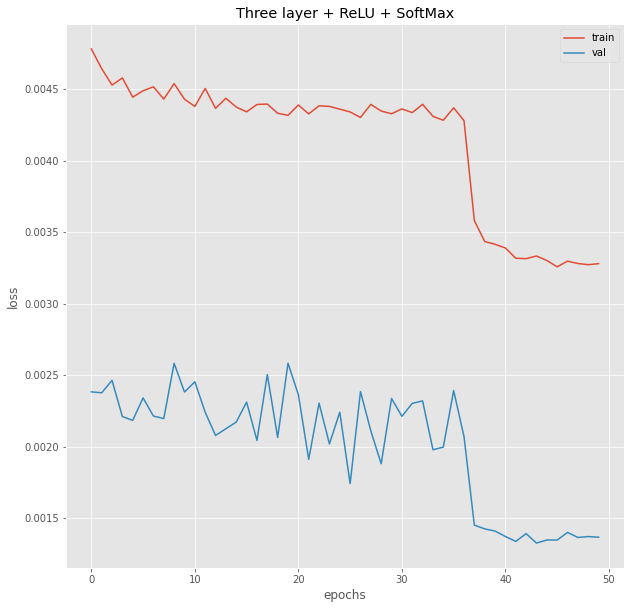

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(loss_history_1['train'], label='train')
ax.plot(loss_history_1['val'], label='val')
ax.set_title('Three layer + ReLU + SoftMax')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.legend();

### Задание 7

Модифицируйте процесс обучения таким образом, чтобы достигнуть наилучшего качества на валидационной выборке. Модель должна оставаться N-слойным перцептроном с количеством обучаемых параметров <= 500000. Для обучения разрешается использовать только набор данных MNIST. Процесс обучения вы можете изменять по собственному усмотрению. К примеру, вы можете менять:

* Архитектуру модели в рамках наложенных ограничений на количество параметров и вид архитектуры (многослойный перцептрон)
* Функции активации в модели
* Используемый оптимизатор
* Расписание шага оптимизации
* Сэмплинг данных при обучении ( e.g. hard negative mining)

В результате мы ожидаем увидеть код экспериментов и любые инсайты, которые вы сможете получить в процессе

In [22]:
class CustomNet(torch.nn.Module):
    def __init__(
        self, 
        input_resolution: Tuple[int, int] = (28, 28),
        input_channels: int = 1,
        hidden_layers_number: int = 3,
        hidden_layers_feature_number: List[int] = (400, 256, 128),
        activation: Type[torch.nn.Module] = torch.nn.GELU,
        num_classes: int = 10,
    ):
        assert len(hidden_layers_feature_number) == hidden_layers_number

        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.hidden_layers_number = hidden_layers_number
        self.activation = activation()

        # создаем скрытые слои в количестве hidden_layers_number
        out_features = input_resolution[0] * input_resolution[1] * input_channels
        for i, out in enumerate(hidden_layers_feature_number):
            layer_name = f"linear_{i+1}"
            in_features = out_features
            out_features = out
            setattr(self, layer_name, torch.nn.Linear(in_features=in_features, out_features=out_features))
            last_iter = i
        setattr(self, f'linear_{last_iter + 2}', torch.nn.Linear(in_features=out_features, out_features=num_classes))

    def forward(self, input_):
        pred = self.flatten(input_)

        for i in range(self.hidden_layers_number):
            pred = self.activation(getattr(self, f"linear_{i + 1}")(pred))
            last_iter = i

        pred = getattr(self, f"linear_{last_iter + 2}")(pred)

        return pred

In [23]:
model = CustomNet()
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

CustomNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): GELU()
  (linear_1): Linear(in_features=784, out_features=400, bias=True)
  (linear_2): Linear(in_features=400, out_features=256, bias=True)
  (linear_3): Linear(in_features=256, out_features=128, bias=True)
  (linear_4): Linear(in_features=128, out_features=10, bias=True)
)
Total number of trainable parameters 450842


In [25]:
model.to(device)
print(device)
loss_history_2 = train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01,
            max_epochs=50)


  0%|          | 0/50 [00:00<?, ?it/s]

cuda
Epoch 0



  2%|▏         | 1/50 [00:48<39:18, 48.12s/it]

Validation metrics: 
{'loss': 0.002576078274101019, 'accuracy': 0.8947}
Best model yet, saving
Epoch 1



  4%|▍         | 2/50 [01:35<38:18, 47.88s/it]

Validation metrics: 
{'loss': 0.0022924822732806206, 'accuracy': 0.909}
Best model yet, saving
Epoch 2



  6%|▌         | 3/50 [02:22<37:21, 47.70s/it]

Validation metrics: 
{'loss': 0.0018399631222710013, 'accuracy': 0.9328}
Best model yet, saving
Epoch 3



  8%|▊         | 4/50 [03:10<36:31, 47.65s/it]

Validation metrics: 
{'loss': 0.0023853488193824888, 'accuracy': 0.9151}
Epoch 4



 10%|█         | 5/50 [03:58<35:49, 47.77s/it]

Validation metrics: 
{'loss': 0.0019090223172679543, 'accuracy': 0.9282}
Epoch 5



 12%|█▏        | 6/50 [04:45<34:48, 47.45s/it]

Validation metrics: 
{'loss': 0.0022586179729551076, 'accuracy': 0.9135}
Epoch 6



 14%|█▍        | 7/50 [05:32<33:55, 47.33s/it]

Validation metrics: 
{'loss': 0.0020893087461590766, 'accuracy': 0.9215}
Epoch 7



 16%|█▌        | 8/50 [06:20<33:15, 47.52s/it]

Validation metrics: 
{'loss': 0.0021258532078936698, 'accuracy': 0.9201}
Epoch 8



 18%|█▊        | 9/50 [07:07<32:32, 47.63s/it]

Validation metrics: 
{'loss': 0.0019421454637311398, 'accuracy': 0.9261}
Epoch 9



 20%|██        | 10/50 [07:55<31:47, 47.70s/it]

Validation metrics: 
{'loss': 0.0019096558194141835, 'accuracy': 0.9332}
Epoch 10



 22%|██▏       | 11/50 [08:43<31:06, 47.85s/it]

Validation metrics: 
{'loss': 0.0016880548583925702, 'accuracy': 0.9404}
Best model yet, saving
Epoch 11



 24%|██▍       | 12/50 [09:31<30:15, 47.79s/it]

Validation metrics: 
{'loss': 0.0017243490404682234, 'accuracy': 0.9344}
Epoch 12



 26%|██▌       | 13/50 [10:18<29:23, 47.65s/it]

Validation metrics: 
{'loss': 0.0015372066048090346, 'accuracy': 0.9429}
Best model yet, saving
Epoch 13



 28%|██▊       | 14/50 [11:05<28:28, 47.45s/it]

Validation metrics: 
{'loss': 0.0017202804827364162, 'accuracy': 0.9402}
Epoch 14



 30%|███       | 15/50 [11:52<27:35, 47.30s/it]

Validation metrics: 
{'loss': 0.001622065819008276, 'accuracy': 0.9402}
Epoch 15



 32%|███▏      | 16/50 [12:39<26:42, 47.13s/it]

Validation metrics: 
{'loss': 0.0018029913429636509, 'accuracy': 0.9353}
Epoch 16



 34%|███▍      | 17/50 [13:26<25:57, 47.19s/it]

Validation metrics: 
{'loss': 0.0015767764309770427, 'accuracy': 0.9433}
Epoch 17



 36%|███▌      | 18/50 [14:13<25:05, 47.06s/it]

Validation metrics: 
{'loss': 0.0015376006921054796, 'accuracy': 0.9441}
Epoch 18



 38%|███▊      | 19/50 [15:01<24:22, 47.17s/it]

Validation metrics: 
{'loss': 0.0015674627794418485, 'accuracy': 0.9427}
Epoch 19



 40%|████      | 20/50 [15:49<23:44, 47.49s/it]

Validation metrics: 
{'loss': 0.0014887720946688205, 'accuracy': 0.9487}
Best model yet, saving
Epoch 20



 42%|████▏     | 21/50 [16:38<23:08, 47.87s/it]

Validation metrics: 
{'loss': 0.001673971967981197, 'accuracy': 0.9387}
Epoch 21



 44%|████▍     | 22/50 [17:26<22:21, 47.93s/it]

Validation metrics: 
{'loss': 0.001550423437077552, 'accuracy': 0.9457}
Epoch 22



 46%|████▌     | 23/50 [18:14<21:33, 47.91s/it]

Validation metrics: 
{'loss': 0.0015838517696014605, 'accuracy': 0.9468}
Epoch 23



 48%|████▊     | 24/50 [19:01<20:42, 47.77s/it]

Validation metrics: 
{'loss': 0.0013193475684267469, 'accuracy': 0.9493}
Best model yet, saving
Epoch 24



 50%|█████     | 25/50 [19:49<19:53, 47.74s/it]

Validation metrics: 
{'loss': 0.001591248350450769, 'accuracy': 0.9411}
Epoch 25



 52%|█████▏    | 26/50 [20:37<19:08, 47.84s/it]

Validation metrics: 
{'loss': 0.0017560937147587537, 'accuracy': 0.9381}
Epoch 26



 54%|█████▍    | 27/50 [21:24<18:15, 47.61s/it]

Validation metrics: 
{'loss': 0.001576846819696948, 'accuracy': 0.9422}
Epoch 27



 56%|█████▌    | 28/50 [22:11<17:24, 47.48s/it]

Validation metrics: 
{'loss': 0.001632337899133563, 'accuracy': 0.9425}
Epoch 28



 58%|█████▊    | 29/50 [22:58<16:35, 47.43s/it]

Validation metrics: 
{'loss': 0.001460296551254578, 'accuracy': 0.9482}
Epoch 29



 60%|██████    | 30/50 [23:46<15:48, 47.45s/it]

Validation metrics: 
{'loss': 0.0017140360149322078, 'accuracy': 0.9433}
Epoch 30



 62%|██████▏   | 31/50 [24:34<15:08, 47.79s/it]

Validation metrics: 
{'loss': 0.0015451486623845995, 'accuracy': 0.9441}
Epoch 31



 64%|██████▍   | 32/50 [25:22<14:19, 47.76s/it]

Validation metrics: 
{'loss': 0.0015865222229389474, 'accuracy': 0.9417}
Epoch 32



 66%|██████▌   | 33/50 [26:09<13:29, 47.59s/it]

Validation metrics: 
{'loss': 0.001680858314409852, 'accuracy': 0.9429}
Epoch 33



 68%|██████▊   | 34/50 [26:56<12:39, 47.44s/it]

Validation metrics: 
{'loss': 0.0017018947340140585, 'accuracy': 0.9435}
Epoch 34



 70%|███████   | 35/50 [27:44<11:50, 47.35s/it]

Validation metrics: 
{'loss': 0.0018973960293456912, 'accuracy': 0.9346}
Epoch 35



 72%|███████▏  | 36/50 [28:31<11:03, 47.39s/it]

Validation metrics: 
{'loss': 0.0011092499452410266, 'accuracy': 0.9592}
Best model yet, saving
Epoch 36



 74%|███████▍  | 37/50 [29:18<10:13, 47.20s/it]

Validation metrics: 
{'loss': 0.0011011336763913277, 'accuracy': 0.9594}
Best model yet, saving
Epoch 37



 76%|███████▌  | 38/50 [30:04<09:24, 47.03s/it]

Validation metrics: 
{'loss': 0.0010369273633579724, 'accuracy': 0.9599}
Best model yet, saving
Epoch 38



 78%|███████▊  | 39/50 [30:52<08:39, 47.18s/it]

Validation metrics: 
{'loss': 0.0010587860061088577, 'accuracy': 0.9602}
Epoch 39



 80%|████████  | 40/50 [31:40<07:55, 47.54s/it]

Validation metrics: 
{'loss': 0.0010204961729803471, 'accuracy': 0.9613}
Best model yet, saving
Epoch 40



 82%|████████▏ | 41/50 [32:29<07:10, 47.79s/it]

Validation metrics: 
{'loss': 0.0010331250925606583, 'accuracy': 0.9597}
Epoch 41



 84%|████████▍ | 42/50 [33:17<06:23, 47.89s/it]

Validation metrics: 
{'loss': 0.0010296130891714712, 'accuracy': 0.9607}
Epoch 42



 86%|████████▌ | 43/50 [34:06<05:37, 48.23s/it]

Validation metrics: 
{'loss': 0.0009962278833903838, 'accuracy': 0.962}
Best model yet, saving
Epoch 43



 88%|████████▊ | 44/50 [34:55<04:50, 48.40s/it]

Validation metrics: 
{'loss': 0.0009816076930437702, 'accuracy': 0.9628}
Best model yet, saving
Epoch 44



 90%|█████████ | 45/50 [35:43<04:01, 48.37s/it]

Validation metrics: 
{'loss': 0.0009980100916349328, 'accuracy': 0.9598}
Epoch 45



 92%|█████████▏| 46/50 [36:30<03:11, 47.94s/it]

Validation metrics: 
{'loss': 0.0009907854673045222, 'accuracy': 0.9612}
Epoch 46



 94%|█████████▍| 47/50 [37:17<02:22, 47.60s/it]

Validation metrics: 
{'loss': 0.000976883555421955, 'accuracy': 0.9614}
Best model yet, saving
Epoch 47



 96%|█████████▌| 48/50 [38:04<01:34, 47.43s/it]

Validation metrics: 
{'loss': 0.0009582744203537004, 'accuracy': 0.9627}
Best model yet, saving
Epoch 48



 98%|█████████▊| 49/50 [38:51<00:47, 47.38s/it]

Validation metrics: 
{'loss': 0.0009673882809234783, 'accuracy': 0.9612}
Epoch 49



100%|██████████| 50/50 [39:38<00:00, 47.57s/it]

Validation metrics: 
{'loss': 0.0009517223917704541, 'accuracy': 0.9625}
Best model yet, saving


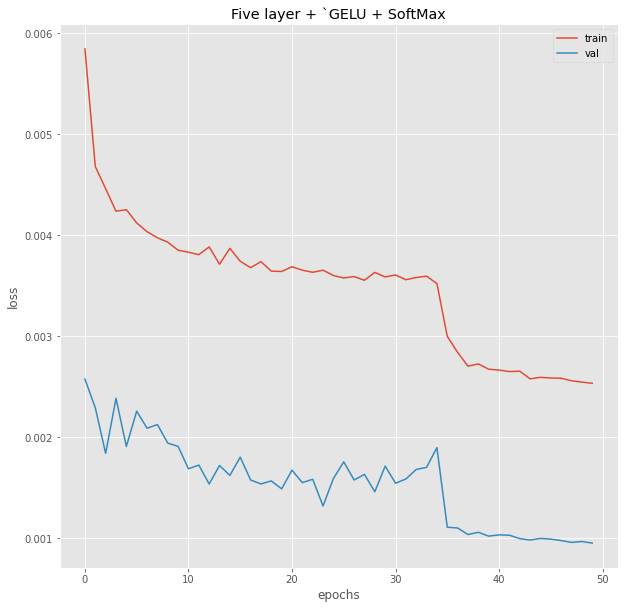

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(loss_history_2['train'], label='train')
ax.plot(loss_history_2['val'], label='val')
ax.set_title('Five layer + `GELU + SoftMax')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.legend();

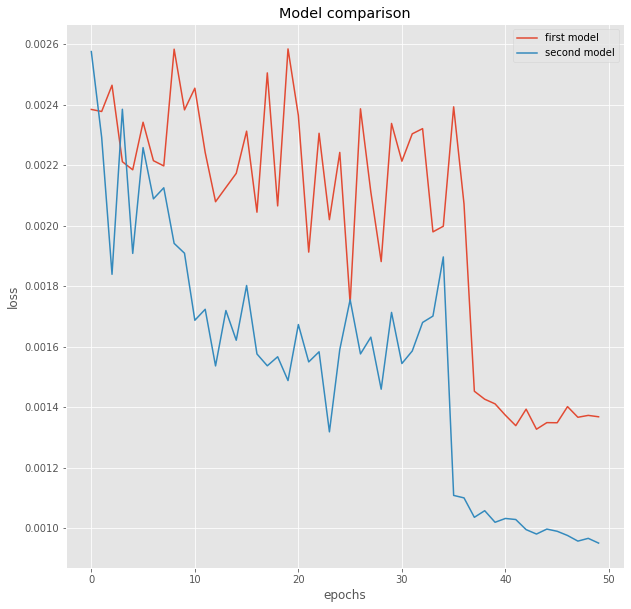

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(loss_history_1['val'], label='first model')
ax.plot(loss_history_2['val'], label='second model')
ax.set_title('Model comparison')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.legend();

# Вывод
В данной работе были реализованы две модели: полносвязная нейронная сеть с одним скрытым слоем и `ReLU + SoftMax` функциями активации, и также полносвязная нейронная сеть, но уже с тремя скрытыми слоями и `GELU + SoftMax`. Концептуально, во второй архитектуре использовалась `GELU`, чтобы попытаться заменить связку `ReLU + BatchNorm` для более глубокой модели.

То, что даже трехслойный перцептрон может справиться с задачей классификации `MNIST`, было ясно из прошлого ДЗ, где аналогичная архитектура реализовывалась на чистом `NumPy`.

Из графиков лосса для обеих моделей видим, что на валидационной выборке качетство лучше, но тому есть две причины:

- на тренировке использовались аугментированные данные, которые усложняют задачу для модели на трэйне, в то время как на тесте для модели более простые данные без аугментации.

- лосс на валидационной считался уже в конце эпохи, когда модель успела сделать шаг оптимизации на тренировке.

В целом, как и ожидалось, более сложная модель решила задачу лучше, тому свидетель значение метрики. 

Что еще любопытно: если сравнивать  PyTorch'овская модель на GPU обучалась на 50 эпохах примерно столько же, сколько на 100 эпохах обучалась модель на NumPy из прошлого ДЗ (на CPU)!!! Возможно, это из-за более сложного оптимизатора (здесь был Adam, там Momentum), но все же, GPU должен это компенсировать с лихвой. 


Скорее всего модели недообучились, потому что видно, что примерно на 35 эпохе снижение learning rate по расписанию приводит к снижению лосса, но в общем-то меня устраивает и полученно на 50 эпохах качество :)

